##### Multi-class Classification on PASCAL 2012 Dataset (PyTorch)

##### Initial Setup

In [1]:
# append the site-packages for the vision-environment
import sys
sys.path.append('C:\\Users\\PrateekTripathi\\Anaconda3\\envs\\vision\\lib\\site-packages')

In [2]:
# import the required libraries
%matplotlib inline 

from pathlib import Path                             # for defining the path
from typing import Union                             # to add exceptions for the type of arguments
from PIL import Image, ImageDraw, ImageFont          # quitessential imaging library
from matplotlib import patches, patheffects          # to draw bounding boxes around the images

import matplotlib.pyplot as plt                      # for drawing the images
import json                                          # for better access to the .json files
import torch                                         # deep learning
import numpy as np                                   # numpy as usual
import collections                                   # for using specific data structures

import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MultiLabelBinarizer
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import math
import os
import copy
import cv2

print('PyTorch Version: ', torch.__version__)
print('Torchvision Version: ', torchvision.__version__)

PyTorch Version:  0.4.1
Torchvision Version:  0.2.1


In [3]:
PATH = Path('VOC2012')                               # define the path

# open and extract the data from the .json file

train = json.load((PATH/'pascal_train2012.json').open())                # train set           
validate = json.load((PATH/'pascal_val2012.json').open())               # validation set

images, annotations, categories = 'images', 'annotations', 'categories'
file_name, ID, image_id, category_id, bbox = 'file_name', 'id', 'image_id', 'category_id', 'bbox'

# create data structures to store information related to data

train_categories = dict((i[ID], i['name']) for i in train[categories])
train_file_names = dict((i[ID], i[file_name]) for i in train[images])
train_ids = [i[ID] for i in train[images]]

validate_categories = dict((i[ID], i['name']) for i in validate[categories])
validate_file_names = dict((i[ID], i[file_name]) for i in validate[images])
validate_ids = [i[ID] for i in validate[images]]

JPEGS = 'JPEGImages'                                 # figure out the path to the images
IMAGES_PATH = PATH/JPEGS                             # define the path for images

In [4]:
len(train_ids)

5717

In [5]:
train_categories

{1: 'aeroplane',
 2: 'bicycle',
 3: 'bird',
 4: 'boat',
 5: 'bottle',
 6: 'bus',
 7: 'car',
 8: 'cat',
 9: 'chair',
 10: 'cow',
 11: 'diningtable',
 12: 'dog',
 13: 'horse',
 14: 'motorbike',
 15: 'person',
 16: 'pottedplant',
 17: 'sheep',
 18: 'sofa',
 19: 'train',
 20: 'tvmonitor'}

In [6]:
# define a function to return train annotations

def get_annotations(dataset):
    
    return_annotations = collections.defaultdict(lambda: [])
    for i in dataset[annotations]:
        
        if not i['ignore']:
            
            bb = i[bbox]
            bb = np.array([bb[1], bb[0], bb[3] + bb[1] - 1, bb[2] + bb[0] - 1])
            return_annotations[i[image_id]].append((bb, i[category_id]))
            
    return return_annotations
    
train_annotations = get_annotations(train)
validate_annotations = get_annotations(validate)

##### Define Functions to Display an Image

In [7]:
def bb_original(bb): 
    
    return np.array([bb[1], bb[0], bb[3] - bb[1] + 1, bb[2] - bb[0] + 1])

In [8]:
def draw_image_plt(image, annotate, ax = None, dataset = 'train'):
    
    if not ax:
        fig, ax = plt.subplots(figsize = (16, 8))
        
    ax.imshow(image)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    for box, obj in annotate:
        
        box = bb_original(box)
        
        patch = ax.add_patch(patches.Rectangle(box[ :2], *box[-2: ], fill = False, edgecolor = 'white', lw = 1))
        patch.set_path_effects([patheffects.Stroke(linewidth = 0.5, foreground = 'black'), 
                                patheffects.Normal()])
        
        if dataset == 'train':
            text = ax.text(*box[:2], train_categories[obj], verticalalignment = 'top', color = 'white', 
                           fontsize = 10, weight = 'bold')
        else:
            text = ax.text(*box[:2], validate_categories[obj], verticalalignment = 'top', color = 'white', 
                           fontsize = 10, weight = 'bold')
        text.set_path_effects([patheffects.Stroke(linewidth = 0.5, foreground = 'black'), 
                               patheffects.Normal()])

# define a function to draw the image with all its bounding boxes using Matplotlib, 
# and return it's Numpy nd.array/Torch tensor

def draw_image(i, dataset, draw = True):
    """This function the position of an image in the folder, and draws the image with its bounding boxes"""
                               
    if dataset == 'train':
        image_id = train[images][i][ID]                         # get the image id from the images .json for the position
        file_name = train_file_names[image_id]                  # get the name of the file from train_fnames dictionary
        bounding_boxes = train_annotations[image_id]            # fetch the bounding boxes from train_annotations default dict
    else:
        image_id = validate[images][i][ID]
        file_name = validate_file_names[image_id]
        bounding_boxes = validate_annotations[image_id]
        
    print(file_name)
    
    image = Image.open(IMAGES_PATH/file_name).convert('RGB')          # open the image at the given location
    
    # draw the image
    
    if draw:
        draw_image_plt(image, bounding_boxes, dataset = dataset)
    else:
        return image

2008_000041.jpg


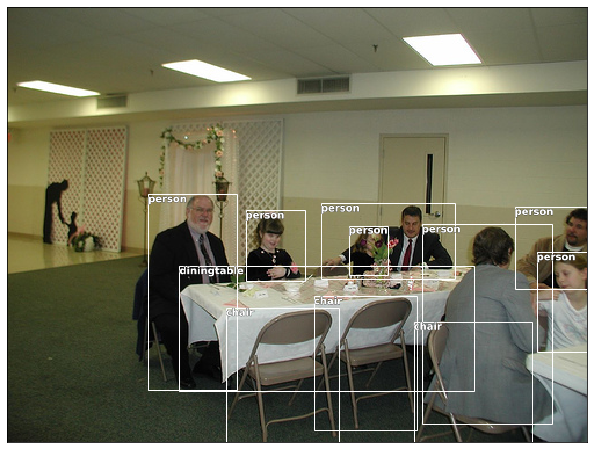

In [9]:
draw_image(8, 'train')

2008_000032.jpg


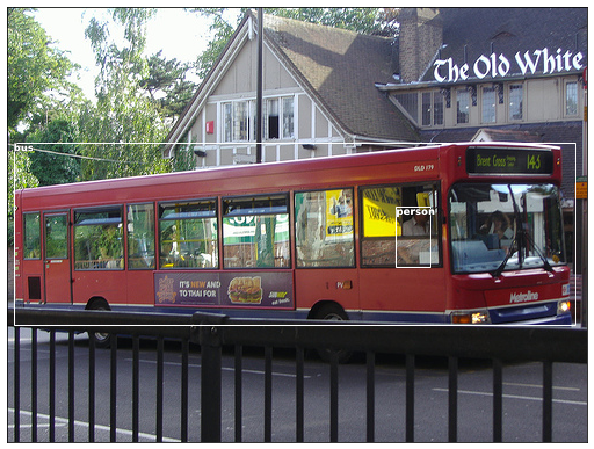

In [10]:
draw_image(8, 'validate')

##### Multi-class Classification Setup

In [11]:
multi_class = PATH/'Temporary/multi_class.csv'
multi_class_validate = PATH/'Temporary/multi_class_validate.csv'

In [12]:
train_annotations[2008000041]

[(array([169, 270, 233, 385]), 15),
 (array([188, 294, 230, 327]), 15),
 (array([175, 205, 235, 255]), 15),
 (array([161, 121, 329, 197]), 15),
 (array([211, 456, 296, 499]), 15),
 (array([172, 437, 242, 499]), 15),
 (array([271, 350, 374, 451]), 9),
 (array([249, 264, 363, 352]), 9),
 (array([259, 188, 374, 285]), 9),
 (array([223, 148, 330, 401]), 11),
 (array([187, 357, 358, 468]), 15)]

In [13]:
# extract categories for each of the image

multi_categories = [set([train_categories[p[1]] for p in train_annotations[i]]) for i in train_ids]
multi_categories_validate = [set([validate_categories[p[1]] for p in validate_annotations[i]]) for i in validate_ids]

multi_categories_ids = [list(set([int(p[1]) for p in train_annotations[i]])) for i in train_ids]
multi_categories_ids_validate = [list(set([p[1] for p in validate_annotations[i]])) for i in validate_ids]

multi_class_structure = [' '.join(str(p) for p in i) for i in multi_categories]
multi_class_structure_validate = [' '.join(str(p) for p in i) for i in multi_categories_validate]

In [14]:
multi_categories[:5]

[{'horse', 'person'},
 {'bottle'},
 {'dog'},
 {'bottle', 'person', 'tvmonitor'},
 {'car'}]

In [15]:
multi_categories_ids[:5]

[[13, 15], [5], [12], [20, 5, 15], [7]]

In [16]:
multi_class_structure[:5]

['horse person', 'bottle', 'dog', 'bottle person tvmonitor', 'car']

In [17]:
df_multi_class = pd.DataFrame({'file_name': [train_file_names[i] for i in train_ids], 'classes': multi_categories_ids}, 
                                     columns = ['file_name', 'classes'])

df_multi_class_validate = pd.DataFrame({'file_name': [validate_file_names[i] for i in validate_ids], 
                                        'classes': multi_categories_ids_validate}, columns = ['file_name', 'classes'])

In [18]:
df_multi_class[:5]

,file_name,classes
0,2008_000008.jpg,"[13, 15]"
1,2008_000015.jpg,[5]
2,2008_000019.jpg,[12]
3,2008_000023.jpg,"[20, 5, 15]"
4,2008_000028.jpg,[7]


In [19]:
df_multi_class.to_csv(multi_class, index = False)
df_multi_class_validate.to_csv(multi_class_validate, index = False)

##### Define the Model and Train Functions for Multi-class Classification

In [20]:
# import the resnet34 model pretrained on imagenet from torchvision

model_multi_class = models.resnet34(pretrained = True)

In [21]:
def train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs = 25):
    
    since = time.time()
    
    val_acc_history = []
    
    learning_rates = []
    
    best_model_weights = copy.deepcopy(model.state_dict())
    best_accuracy = 0.0
    
    for epoch in range(num_epochs):
        
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        # each epoch has a training and validation phase; pending addition of the 'validate' phase
        
        for phase in ['train', 'validate']:
            if phase == 'train':
                model.train()                   # set model to training mode
            else:
                model.eval()                    # set model to evaluate mode
                
            running_loss = 0.0
            running_corrects = 0
            
            # iterate over the data
            for a, data in enumerate(dataloaders[phase]):
                
                inputs = data['image'].to(device)
                labels = data['label'].to(device)
                
                optimizer.zero_grad()          # zero the parameter gradient
                
                print("Batch Number:", a)
                
                # forward propagation
                
                with torch.set_grad_enabled(phase == 'train'):     # update the weights only when it's in the 'train' phase
                    
                    outputs = model(inputs)                    
                    loss = criterion(torch.sigmoid(outputs), labels)     
                    
                    '''if a < 2:
                        print(outputs[0] >= 0.5)
                        print(labels[0])
                    else:
                        break'''
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum((outputs >= 0.5).to(dtype = torch.float) == labels)
                
                print("Running Loss:", loss.item() * inputs.size(0))
                print("Running Corrects:", torch.sum((outputs >= 0.5).to(dtype = torch.float) == labels), '\n')
                
                scheduler.step()
                
                x = 0 
                
                for i in optimizer.param_groups:
                    x = i['lr']
                    print(x)
                    break
                
                learning_rates.append(x)
                
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_accuracy = running_corrects.double() / (len(dataloaders[phase].dataset) * 20)
            
            print('{} Loss: {:.4f} Accuracy: {:.4f}'.format(phase, epoch_loss, epoch_accuracy))
            
            if phase == 'validate' and epoch_accuracy > best_accuracy:
                best_accuracy = epoch_accuracy
                best_model_weights = copy.deepcopy(model.state_dict())
            if phase == 'validate':
                val_acc_history.append(epoch_accuracy)
                
        print()
        
    time_elapsed = time.time() - since
    print('Training Complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best Value Accuracy: {:.4f}'.format(best_accuracy))     
    
    # it doesn't print this as we haven't configured the 'validate' phase
    
    # load best model weights
    model.load_state_dict(best_model_weights)        # avoid using this if we do not have a validation set
    return model, val_acc_history

In [22]:
# define a function to the freeze the layers upto a certain layer number, 
# this also returns the parameters that we will pass to the optimizer to update/train

flatten_model = lambda m: sum(map(flatten_model, m.children()),[]) if len(list(m.children())) else [m]

def freeze_to(model, n):
    "Freeze layers up to layer `n`."
    
    bn_types = (nn.BatchNorm1d, nn.BatchNorm2d, nn.BatchNorm3d)
    
    layers = nn.Sequential(*flatten_model(model))
    
    params_to_update = [] 
    for g in layers[:n]:
        if not isinstance(g, bn_types):
            for p in g.parameters():
                p.requires_grad = False
    for g in layers[n:]:
        print(g)
        for p in g.parameters():
            params_to_update.append(p)
             
    return params_to_update

parameters_to_update = freeze_to(model_multi_class, -1)

parameters_to_update

Linear(in_features=512, out_features=1000, bias=True)


[Parameter containing:
 tensor([[-0.0564, -0.0554,  0.0254,  ...,  0.1835,  0.0218, -0.0415],
         [-0.0969, -0.0573,  0.0534,  ...,  0.2416, -0.0703, -0.0030],
         [-0.0257,  0.0436, -0.0174,  ...,  0.1816,  0.0426,  0.0077],
         ...,
         [-0.0432,  0.0068,  0.0601,  ..., -0.0376,  0.0455,  0.0833],
         [-0.0865, -0.0468,  0.1040,  ..., -0.0176, -0.0083,  0.0444],
         [ 0.0042, -0.0356, -0.0443,  ..., -0.0197, -0.0797,  0.1877]],
        requires_grad=True), Parameter containing:
 tensor([ 0.0000, -0.0036, -0.0112, -0.0139,  0.0124, -0.0023, -0.0055,  0.0064,
          0.0053, -0.0104, -0.0091, -0.0050, -0.0090, -0.0118, -0.0125, -0.0134,
         -0.0095, -0.0122,  0.0017, -0.0110,  0.0059,  0.0131, -0.0004,  0.0012,
         -0.0020,  0.0035,  0.0126, -0.0094,  0.0017, -0.0026, -0.0071, -0.0022,
         -0.0006, -0.0047, -0.0046, -0.0139, -0.0011, -0.0130,  0.0046, -0.0023,
         -0.0027, -0.0017,  0.0035, -0.0113,  0.0119, -0.0008,  0.0168, -0.0191,

In [23]:
# check out the last layer

print(model_multi_class.fc)

Linear(in_features=512, out_features=1000, bias=True)


In [24]:
model_multi_class.fc = nn.Linear(in_features = 512, out_features = 20, bias = True)

In [25]:
# check out the re-initialized layer

print(model_multi_class.fc)

Linear(in_features=512, out_features=20, bias=True)


##### Configure the Data Load for the Multi-class Model

In [26]:
# data augmentation and normalization for training; only normalization for validation

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomRotation(10),
        transforms.ColorJitter(0.05, 0.05),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]), 
    'validate': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

We have finally arrived at the dataset represented in the form of the .csv file with input file names along with their corresponding labels; we need to import this .csv file and create a torch dataset and dataloader!

In [27]:
multi_class_df = pd.read_csv(multi_class)
multi_class_df_validate = pd.read_csv(multi_class_validate)

In [28]:
multi_class_df.head()

,file_name,classes
0,2008_000008.jpg,"[13, 15]"
1,2008_000015.jpg,[5]
2,2008_000019.jpg,[12]
3,2008_000023.jpg,"[20, 5, 15]"
4,2008_000028.jpg,[7]


In [29]:
multi_class_df_validate.head()

,file_name,classes
0,2008_000002.jpg,[20]
1,2008_000003.jpg,"[19, 15]"
2,2008_000007.jpg,[4]
3,2008_000009.jpg,[10]
4,2008_000016.jpg,[20]


In [30]:
multi_label_binarizer = MultiLabelBinarizer()
multi_label_encoded = multi_label_binarizer.fit_transform(multi_categories_ids)
multi_label_encoded_validate = multi_label_binarizer.fit_transform(multi_categories_ids_validate)

In [31]:
multi_label_encoded

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 1, ..., 0, 0, 0]])

In [32]:
multi_class_df = multi_class_df.join(pd.DataFrame(multi_label_encoded))
multi_class_df_validate = multi_class_df_validate.join(pd.DataFrame(multi_label_encoded_validate))

In [33]:
multi_class_df.head()

,file_name,classes,0,1,2,3,4,5,6,7,...,10,11,12,13,14,15,16,17,18,19
0,2008_000008.jpg,"[13, 15]",0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
1,2008_000015.jpg,[5],0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2008_000019.jpg,[12],0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,2008_000023.jpg,"[20, 5, 15]",0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,1
4,2008_000028.jpg,[7],0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [34]:
multi_class_df.to_csv(multi_class, index = False)

In [35]:
multi_class_df_validate.to_csv(multi_class_validate, index = False)

This is how we define the PASCAL dataset class as an extension of the torchvision's Dataset class

In [36]:
class Multi_Class_Dataset(Dataset):
    
    def __init__(self, csv_file, root_dir, transform = None):
        
        self.multi_class_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        
    def __len__(self):
        
        return len(self.multi_class_frame)
    
    def __getitem__(self, idx):
        
        image_name = os.path.join(self.root_dir, self.multi_class_frame.loc[idx, 'file_name'])
        image = Image.open(image_name).convert('RGB')               # open the image at the given location
        
        labels = np.array(self.multi_class_frame.iloc[idx, 2:])
        labels = np.squeeze(labels.astype('int64'))
        
        sample = {'image': image, 'label': labels}
        
        if self.transform:
            sample['image'] = self.transform(sample['image'])
            sample['label'] = (torch.from_numpy(sample['label'])).to(dtype = torch.float)
            
        return sample

In [37]:
multi_class_image_datasets = {'train': Multi_Class_Dataset(csv_file = multi_class, root_dir = IMAGES_PATH), 
                              'validate': Multi_Class_Dataset(csv_file = multi_class_validate, root_dir = IMAGES_PATH)}

0 <PIL.Image.Image image mode=RGB size=500x375 at 0x1BD6F56BDD8> [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
1 <PIL.Image.Image image mode=RGB size=500x333 at 0x1BD737B8780> [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0]
2 <PIL.Image.Image image mode=RGB size=500x375 at 0x1BD738038D0> [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
3 <PIL.Image.Image image mode=RGB size=500x375 at 0x1BD7383D160> [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]


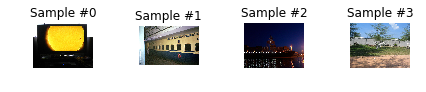

In [38]:
fig = plt.figure()

for i in range(len(multi_class_image_datasets['validate'])):
    
    sample = multi_class_image_datasets['validate'][i]
    
    print(i, sample['image'], sample['label'])
    
    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    ax.imshow(sample['image'])
    
    if i == 3:
        plt.show()
        break

Here we define the dataset object of the PASCALDataset class

In [39]:
transformed_datasets = {'train': Multi_Class_Dataset(csv_file = multi_class, root_dir = IMAGES_PATH, 
                                                     transform = data_transforms['train']),
                        'validate': Multi_Class_Dataset(csv_file = multi_class_validate, root_dir = IMAGES_PATH, 
                                                        transform = data_transforms['validate'])}

for i in range(len(transformed_datasets['train'])):
    sample = transformed_datasets['train'][i]
    
    print(i, sample['image'].size(), sample['label'].size())
    if i == 3:
        break
        
print()

for i in range(len(transformed_datasets['validate'])):
    sample = transformed_datasets['validate'][i]
    
    print(i, sample['image'].size(), sample['label'].size())
    if i == 3:
        break

0 torch.Size([3, 224, 224]) torch.Size([20])
1 torch.Size([3, 224, 224]) torch.Size([20])
2 torch.Size([3, 224, 224]) torch.Size([20])
3 torch.Size([3, 224, 224]) torch.Size([20])

0 torch.Size([3, 224, 224]) torch.Size([20])
1 torch.Size([3, 224, 224]) torch.Size([20])
2 torch.Size([3, 224, 224]) torch.Size([20])
3 torch.Size([3, 224, 224]) torch.Size([20])


In [40]:
multi_class_image_dataloaders = {'train': DataLoader(transformed_datasets['train'], batch_size = 64, shuffle = True),
                                 'validate': DataLoader(transformed_datasets['validate'], batch_size = 64, shuffle = True)}

In [41]:
# test = {}

for i_batch, sample_batched in enumerate(multi_class_image_dataloaders['train']):
    print(i_batch, sample_batched['image'].size(),
          sample_batched['label'].size())
    
    # test[i_batch] = model_4by4_bounding_boxes(sample_batched['image'])
    
    if i_batch == 4:
        break
        
print()
        
for i_batch, sample_batched in enumerate(multi_class_image_dataloaders['validate']):
    print(i_batch, sample_batched['image'].size(),
          sample_batched['label'].size())
    
    if i_batch == 4:
        break

0 torch.Size([64, 3, 224, 224]) torch.Size([64, 20])
1 torch.Size([64, 3, 224, 224]) torch.Size([64, 20])
2 torch.Size([64, 3, 224, 224]) torch.Size([64, 20])
3 torch.Size([64, 3, 224, 224]) torch.Size([64, 20])
4 torch.Size([64, 3, 224, 224]) torch.Size([64, 20])

0 torch.Size([64, 3, 224, 224]) torch.Size([64, 20])
1 torch.Size([64, 3, 224, 224]) torch.Size([64, 20])
2 torch.Size([64, 3, 224, 224]) torch.Size([64, 20])
3 torch.Size([64, 3, 224, 224]) torch.Size([64, 20])
4 torch.Size([64, 3, 224, 224]) torch.Size([64, 20])


In [42]:
'''print(test[0][0].size())
print()
print(test[0][1].size())'''

'print(test[0][0].size())\nprint()\nprint(test[0][1].size())'

##### Run Training and Validation Steps

In [43]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

device

device(type='cuda', index=0)

In [44]:
model_multi_class = model_multi_class.to(device)

In [45]:
parameters_to_update = freeze_to(model_multi_class, -1)

parameters_to_update

Linear(in_features=512, out_features=20, bias=True)


[Parameter containing:
 tensor([[ 0.0170, -0.0117, -0.0083,  ...,  0.0109, -0.0283, -0.0098],
         [ 0.0248,  0.0136,  0.0037,  ...,  0.0161,  0.0112,  0.0183],
         [-0.0175, -0.0068,  0.0276,  ...,  0.0152,  0.0150,  0.0381],
         ...,
         [ 0.0095,  0.0371, -0.0368,  ...,  0.0103,  0.0412, -0.0265],
         [ 0.0080,  0.0425,  0.0189,  ..., -0.0388, -0.0004, -0.0396],
         [-0.0417,  0.0378,  0.0199,  ...,  0.0318, -0.0127, -0.0273]],
        device='cuda:0', requires_grad=True), Parameter containing:
 tensor([ 0.0382,  0.0112,  0.0039, -0.0393,  0.0206,  0.0100, -0.0059, -0.0162,
         -0.0097,  0.0001, -0.0398,  0.0028, -0.0129,  0.0139,  0.0308, -0.0422,
         -0.0302,  0.0363, -0.0386,  0.0241],
        device='cuda:0', requires_grad=True)]

Define the optimizer!

In [46]:
optimizer = optim.SGD(parameters_to_update, lr = 0.02, momentum = 0.9)

# optimizer = optim.Adam(parameters_to_update, lr = 0.02)

In [47]:
criterion = nn.BCELoss()

In [48]:
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = 90, eta_min = 0.002)

In [49]:
model_multi_class, history = train_model(model_multi_class, dataloaders = multi_class_image_dataloaders, 
                                         criterion = criterion, optimizer = optimizer, scheduler = scheduler, 
                                         num_epochs = 5)

Epoch 0/4
----------
Batch Number: 0
Running Loss: 53.2667350769043
Running Corrects: tensor(848, device='cuda:0') 

0.020000000000000004
Batch Number: 1
Running Loss: 46.9761848449707
Running Corrects: tensor(951, device='cuda:0') 

0.019994517443171864
Batch Number: 2
Running Loss: 37.70366668701172
Running Corrects: tensor(1114, device='cuda:0') 

0.01997807645233842
Batch Number: 3
Running Loss: 27.833377838134766
Running Corrects: tensor(1188, device='cuda:0') 

0.01995069705831446
Batch Number: 4
Running Loss: 20.908723831176758
Running Corrects: tensor(1194, device='cuda:0') 

0.019912412618674137
Batch Number: 5
Running Loss: 17.133289337158203
Running Corrects: tensor(1188, device='cuda:0') 

0.019863269777109872
Batch Number: 6
Running Loss: 15.461137771606445
Running Corrects: tensor(1190, device='cuda:0') 

0.019803328406604252
Batch Number: 7
Running Loss: 14.60626220703125
Running Corrects: tensor(1197, device='cuda:0') 

0.019732661536483967
Batch Number: 8
Running Loss:

Batch Number: 68
Running Loss: 12.217096328735352
Running Corrects: tensor(1193, device='cuda:0') 

0.004525941796952138
Batch Number: 69
Running Loss: 11.893301963806152
Running Corrects: tensor(1190, device='cuda:0') 

0.0043116965707034535
Batch Number: 70
Running Loss: 12.050524711608887
Running Corrects: tensor(1189, device='cuda:0') 

0.004105600011929199
Batch Number: 71
Running Loss: 12.531865119934082
Running Corrects: tensor(1187, device='cuda:0') 

0.003907903217539503
Batch Number: 72
Running Loss: 13.507734298706055
Running Corrects: tensor(1189, device='cuda:0') 

0.0037188470506254743
Batch Number: 73
Running Loss: 12.299700736999512
Running Corrects: tensor(1196, device='cuda:0') 

0.0035386618470046255
Batch Number: 74
Running Loss: 13.0830078125
Running Corrects: tensor(1192, device='cuda:0') 

0.0033675671345921665
Batch Number: 75
Running Loss: 14.228815078735352
Running Corrects: tensor(1187, device='cuda:0') 

0.0032057713659400518
Batch Number: 76
Running Loss: 1

Batch Number: 46
Running Loss: 11.387701034545898
Running Corrects: tensor(1202, device='cuda:0') 

0.011314095470322513
Batch Number: 47
Running Loss: 10.372010231018066
Running Corrects: tensor(1203, device='cuda:0') 

0.011627808263697128
Batch Number: 48
Running Loss: 12.015970230102539
Running Corrects: tensor(1187, device='cuda:0') 

0.01194075616940888
Batch Number: 49
Running Loss: 12.787060737609863
Running Corrects: tensor(1189, device='cuda:0') 

0.01225255790864059
Batch Number: 50
Running Loss: 9.969484329223633
Running Corrects: tensor(1204, device='cuda:0') 

0.012562833599002373
Batch Number: 51
Running Loss: 10.785354614257812
Running Corrects: tensor(1206, device='cuda:0') 

0.012871205217359828
Batch Number: 52
Running Loss: 11.452740669250488
Running Corrects: tensor(1196, device='cuda:0') 

0.013177297060397008
Batch Number: 53
Running Loss: 11.88117504119873
Running Corrects: tensor(1193, device='cuda:0') 

0.013480736202352996
Batch Number: 54
Running Loss: 11.98

Batch Number: 23
Running Loss: 10.44369888305664
Running Corrects: tensor(1205, device='cuda:0') 

0.017022175457229734
Batch Number: 24
Running Loss: 10.575573921203613
Running Corrects: tensor(1199, device='cuda:0') 

0.01678508848717886
Batch Number: 25
Running Loss: 11.031506538391113
Running Corrects: tensor(1203, device='cuda:0') 

0.016540953277930932
Batch Number: 26
Running Loss: 10.630983352661133
Running Corrects: tensor(1200, device='cuda:0') 

0.01629006727063227
Batch Number: 27
Running Loss: 10.255819320678711
Running Corrects: tensor(1204, device='cuda:0') 

0.01603273613123672
Batch Number: 28
Running Loss: 10.828927993774414
Running Corrects: tensor(1193, device='cuda:0') 

0.015769273378098848
Batch Number: 29
Running Loss: 10.417439460754395
Running Corrects: tensor(1203, device='cuda:0') 

0.0155
Batch Number: 30
Running Loss: 10.01338005065918
Running Corrects: tensor(1204, device='cuda:0') 

0.015225244065073019
Batch Number: 31
Running Loss: 10.296981811523438
R

Batch Number: 1
Running Loss: 9.117721557617188
Running Corrects: tensor(1203, device='cuda:0') 

0.0020219235476615824
Batch Number: 2
Running Loss: 9.698562622070312
Running Corrects: tensor(1209, device='cuda:0') 

0.0020493029416855406
Batch Number: 3
Running Loss: 8.929182052612305
Running Corrects: tensor(1214, device='cuda:0') 

0.002087587381325867
Batch Number: 4
Running Loss: 8.403287887573242
Running Corrects: tensor(1214, device='cuda:0') 

0.002136730222890127
Batch Number: 5
Running Loss: 8.948917388916016
Running Corrects: tensor(1208, device='cuda:0') 

0.0021966715933957478
Batch Number: 6
Running Loss: 8.95581340789795
Running Corrects: tensor(1209, device='cuda:0') 

0.0022673384635160327
Batch Number: 7
Running Loss: 9.786869049072266
Running Corrects: tensor(1200, device='cuda:0') 

0.00234864473655513
Batch Number: 8
Running Loss: 9.075508117675781
Running Corrects: tensor(1207, device='cuda:0') 

0.0024404913533436173
Batch Number: 9
Running Loss: 9.7792005538940

Batch Number: 70
Running Loss: 8.878667831420898
Running Corrects: tensor(1214, device='cuda:0') 

0.018092096782460487
Batch Number: 71
Running Loss: 9.255758285522461
Running Corrects: tensor(1213, device='cuda:0') 

0.018281152949374525
Batch Number: 72
Running Loss: 9.365097045898438
Running Corrects: tensor(1209, device='cuda:0') 

0.01846133815299538
Batch Number: 73
Running Loss: 9.332182884216309
Running Corrects: tensor(1209, device='cuda:0') 

0.018632432865407833
Batch Number: 74
Running Loss: 9.564753532409668
Running Corrects: tensor(1206, device='cuda:0') 

0.018794228634059953
Batch Number: 75
Running Loss: 9.345942497253418
Running Corrects: tensor(1209, device='cuda:0') 

0.018946528335730344
Batch Number: 76
Running Loss: 8.210991859436035
Running Corrects: tensor(1211, device='cuda:0') 

0.0190891464166925
Batch Number: 77
Running Loss: 9.463432312011719
Running Corrects: tensor(1207, device='cuda:0') 

0.019221909118783402
Batch Number: 78
Running Loss: 10.022635459

Batch Number: 47
Running Loss: 8.724940299987793
Running Corrects: tensor(1212, device='cuda:0') 

0.009747442091359415
Batch Number: 48
Running Loss: 8.75854778289795
Running Corrects: tensor(1217, device='cuda:0') 

0.009437166400997635
Batch Number: 49
Running Loss: 8.854421615600586
Running Corrects: tensor(1213, device='cuda:0') 

0.00912879478264016
Batch Number: 50
Running Loss: 8.253101348876953
Running Corrects: tensor(1212, device='cuda:0') 

0.008822702939603005
Batch Number: 51
Running Loss: 9.08678150177002
Running Corrects: tensor(1204, device='cuda:0') 

0.00851926379764701
Batch Number: 52
Running Loss: 9.367740631103516
Running Corrects: tensor(1201, device='cuda:0') 

0.008218847050625495
Batch Number: 53
Running Loss: 8.139111518859863
Running Corrects: tensor(1213, device='cuda:0') 

0.00792181871006899
Batch Number: 54
Running Loss: 8.919492721557617
Running Corrects: tensor(1203, device='cuda:0') 

0.007628540659256789
Batch Number: 55
Running Loss: 9.102228164672

Running Loss: 7.453194618225098
Running Corrects: tensor(1215, device='cuda:0') 

0.00570993272936775
Batch Number: 26
Running Loss: 9.183016777038574
Running Corrects: tensor(1207, device='cuda:0') 

0.005967263868763271
Batch Number: 27
Running Loss: 7.61652135848999
Running Corrects: tensor(1218, device='cuda:0') 

0.006230726621901159
Batch Number: 28
Running Loss: 6.6951727867126465
Running Corrects: tensor(1235, device='cuda:0') 

0.006499999999999987
Batch Number: 29
Running Loss: 7.642120361328125
Running Corrects: tensor(1220, device='cuda:0') 

0.00677475593492698
Batch Number: 30
Running Loss: 9.272096633911133
Running Corrects: tensor(1196, device='cuda:0') 

0.007054659678898312
Batch Number: 31
Running Loss: 7.963883399963379
Running Corrects: tensor(1216, device='cuda:0') 

0.007339370212317788
Batch Number: 32
Running Loss: 7.8314714431762695
Running Corrects: tensor(1211, device='cuda:0') 

0.007628540659256793
Batch Number: 33
Running Loss: 9.309598922729492
Running C

Batch Number: 3
Running Loss: 9.073568344116211
Running Corrects: tensor(1210, device='cuda:0') 

0.019803328406604252
Batch Number: 4
Running Loss: 7.87539005279541
Running Corrects: tensor(1216, device='cuda:0') 

0.019732661536483974
Batch Number: 5
Running Loss: 7.155123710632324
Running Corrects: tensor(1230, device='cuda:0') 

0.019651355263444872
Batch Number: 6
Running Loss: 8.25565242767334
Running Corrects: tensor(1214, device='cuda:0') 

0.01955950864665639
Batch Number: 7
Running Loss: 9.390142440795898
Running Corrects: tensor(1207, device='cuda:0') 

0.01945723358707318
Batch Number: 8
Running Loss: 9.278131484985352
Running Corrects: tensor(1206, device='cuda:0') 

0.019344654691101103
Batch Number: 9
Running Loss: 8.257534980773926
Running Corrects: tensor(1211, device='cuda:0') 

0.019221909118783416
Batch Number: 10
Running Loss: 8.249608039855957
Running Corrects: tensor(1209, device='cuda:0') 

0.019089146416692508
Batch Number: 11
Running Loss: 7.577094078063965
Ru

Batch Number: 72
Running Loss: 7.9461188316345215
Running Corrects: tensor(1213, device='cuda:0') 

0.003205771365940054
Batch Number: 73
Running Loss: 7.866258144378662
Running Corrects: tensor(1209, device='cuda:0') 

0.0030534716642696535
Batch Number: 74
Running Loss: 8.977677345275879
Running Corrects: tensor(1204, device='cuda:0') 

0.002910853583307501
Batch Number: 75
Running Loss: 7.29998254776001
Running Corrects: tensor(1220, device='cuda:0') 

0.0027780908812165914
Batch Number: 76
Running Loss: 9.052658081054688
Running Corrects: tensor(1205, device='cuda:0') 

0.0026553453088989072
Batch Number: 77
Running Loss: 8.208640098571777
Running Corrects: tensor(1219, device='cuda:0') 

0.002542766412926826
Batch Number: 78
Running Loss: 8.46982479095459
Running Corrects: tensor(1217, device='cuda:0') 

0.002440491353343615
Batch Number: 79
Running Loss: 8.567012786865234
Running Corrects: tensor(1211, device='cuda:0') 

0.002348644736555133
Batch Number: 80
Running Loss: 7.38262

Batch Number: 51
Running Loss: 6.742791652679443
Running Corrects: tensor(1232, device='cuda:0') 

0.013781152949374521
Batch Number: 52
Running Loss: 6.416375637054443
Running Corrects: tensor(1233, device='cuda:0') 

0.014078181289930993
Batch Number: 53
Running Loss: 7.9603424072265625
Running Corrects: tensor(1218, device='cuda:0') 

0.014371459340743225
Batch Number: 54
Running Loss: 8.319818496704102
Running Corrects: tensor(1216, device='cuda:0') 

0.0146606297876822
Batch Number: 55
Running Loss: 7.794900417327881
Running Corrects: tensor(1216, device='cuda:0') 

0.014945340321101678
Batch Number: 56
Running Loss: 8.790349006652832
Running Corrects: tensor(1213, device='cuda:0') 

0.015225244065072982
Batch Number: 57
Running Loss: 8.174245834350586
Running Corrects: tensor(1221, device='cuda:0') 

0.015500000000000003
Batch Number: 58
Running Loss: 8.12431526184082
Running Corrects: tensor(1217, device='cuda:0') 

0.01576927337809883
Batch Number: 59
Running Loss: 6.6964430809

Running Loss: 8.457334518432617
Running Corrects: tensor(1213, device='cuda:0') 

0.014945340321101694
Batch Number: 29
Running Loss: 8.01873779296875
Running Corrects: tensor(1213, device='cuda:0') 

0.014660629787682218
Batch Number: 30
Running Loss: 7.779461860656738
Running Corrects: tensor(1223, device='cuda:0') 

0.014371459340743211
Batch Number: 31
Running Loss: 7.150335788726807
Running Corrects: tensor(1229, device='cuda:0') 

0.014078181289931041
Batch Number: 32
Running Loss: 7.2263946533203125
Running Corrects: tensor(1223, device='cuda:0') 

0.013781152949374537
Batch Number: 33
Running Loss: 7.8246588706970215
Running Corrects: tensor(1220, device='cuda:0') 

0.013480736202352992
Batch Number: 34
Running Loss: 8.234352111816406
Running Corrects: tensor(1225, device='cuda:0') 

0.013177297060397027
Batch Number: 35
Running Loss: 7.166327476501465
Running Corrects: tensor(1224, device='cuda:0') 

0.01287120521735984
Batch Number: 36
Running Loss: 7.803866386413574
Running 

Batch Number: 7
Running Loss: 7.04993200302124
Running Corrects: tensor(1222, device='cuda:0') 

0.002655345308898901
Batch Number: 8
Running Loss: 7.424992561340332
Running Corrects: tensor(1228, device='cuda:0') 

0.002778090881216596
Batch Number: 9
Running Loss: 6.7068047523498535
Running Corrects: tensor(1235, device='cuda:0') 

0.002910853583307494
Batch Number: 10
Running Loss: 7.249495506286621
Running Corrects: tensor(1226, device='cuda:0') 

0.0030534716642696444
Batch Number: 11
Running Loss: 7.337708950042725
Running Corrects: tensor(1229, device='cuda:0') 

0.003205771365940061
Batch Number: 12
Running Loss: 7.794668674468994
Running Corrects: tensor(1221, device='cuda:0') 

0.003367567134592165
Batch Number: 13
Running Loss: 8.464250564575195
Running Corrects: tensor(1224, device='cuda:0') 

0.0035386618470046125
Batch Number: 14
Running Loss: 6.003267765045166
Running Corrects: tensor(1239, device='cuda:0') 

0.003718847050625449
Batch Number: 15
Running Loss: 7.70351696

Batch Number: 76
Running Loss: 7.0608229637146
Running Corrects: tensor(1223, device='cuda:0') 

0.019457233587073165
Batch Number: 77
Running Loss: 7.363102912902832
Running Corrects: tensor(1229, device='cuda:0') 

0.019559508646656384
Batch Number: 78
Running Loss: 7.499798774719238
Running Corrects: tensor(1216, device='cuda:0') 

0.019651355263444865
Batch Number: 79
Running Loss: 6.881449222564697
Running Corrects: tensor(1227, device='cuda:0') 

0.01973266153648396
Batch Number: 80
Running Loss: 6.891412258148193
Running Corrects: tensor(1232, device='cuda:0') 

0.019803328406604252
Batch Number: 81
Running Loss: 7.7457475662231445
Running Corrects: tensor(1218, device='cuda:0') 

0.019863269777109872
Batch Number: 82
Running Loss: 7.26922082901001
Running Corrects: tensor(1220, device='cuda:0') 

0.019912412618674137
Batch Number: 83
Running Loss: 8.45826530456543
Running Corrects: tensor(1219, device='cuda:0') 

0.01995069705831446
Batch Number: 84
Running Loss: 7.040845394134

In [50]:
optimizer_two = optim.Adam(parameters_to_update, lr = 0.02)

In [51]:
model_multi_class, history_two = train_model(model_multi_class, dataloaders = multi_class_image_dataloaders, 
                                             criterion = criterion, optimizer = optimizer_two, scheduler = scheduler, 
                                             num_epochs = 2)

Epoch 0/1
----------
Batch Number: 0
Running Loss: 7.794933319091797
Running Corrects: tensor(1216, device='cuda:0') 

0.02
Batch Number: 1
Running Loss: 67.15265655517578
Running Corrects: tensor(929, device='cuda:0') 

0.02
Batch Number: 2
Running Loss: 15.931936264038086
Running Corrects: tensor(1171, device='cuda:0') 

0.02
Batch Number: 3
Running Loss: 27.443029403686523
Running Corrects: tensor(1121, device='cuda:0') 

0.02
Batch Number: 4
Running Loss: 34.28943634033203
Running Corrects: tensor(1142, device='cuda:0') 

0.02
Batch Number: 5
Running Loss: 31.285659790039062
Running Corrects: tensor(1184, device='cuda:0') 

0.02
Batch Number: 6
Running Loss: 28.499156951904297
Running Corrects: tensor(1193, device='cuda:0') 

0.02
Batch Number: 7
Running Loss: 28.970001220703125
Running Corrects: tensor(1207, device='cuda:0') 

0.02
Batch Number: 8
Running Loss: 30.29022789001465
Running Corrects: tensor(1195, device='cuda:0') 

0.02
Batch Number: 9
Running Loss: 31.956640243530273

Batch Number: 79
Running Loss: 6.341210842132568
Running Corrects: tensor(1245, device='cuda:0') 

0.02
Batch Number: 80
Running Loss: 7.694713592529297
Running Corrects: tensor(1232, device='cuda:0') 

0.02
Batch Number: 81
Running Loss: 6.178452968597412
Running Corrects: tensor(1237, device='cuda:0') 

0.02
Batch Number: 82
Running Loss: 7.157200813293457
Running Corrects: tensor(1233, device='cuda:0') 

0.02
Batch Number: 83
Running Loss: 7.434720039367676
Running Corrects: tensor(1235, device='cuda:0') 

0.02
Batch Number: 84
Running Loss: 9.31857681274414
Running Corrects: tensor(1224, device='cuda:0') 

0.02
Batch Number: 85
Running Loss: 5.962027072906494
Running Corrects: tensor(1244, device='cuda:0') 

0.02
Batch Number: 86
Running Loss: 8.922813415527344
Running Corrects: tensor(1220, device='cuda:0') 

0.02
Batch Number: 87
Running Loss: 8.440393447875977
Running Corrects: tensor(1233, device='cuda:0') 

0.02
Batch Number: 88
Running Loss: 7.931780815124512
Running Corrects

Batch Number: 68
Running Loss: 7.640995025634766
Running Corrects: tensor(1234, device='cuda:0') 

0.02
Batch Number: 69
Running Loss: 8.349386215209961
Running Corrects: tensor(1232, device='cuda:0') 

0.02
Batch Number: 70
Running Loss: 6.879809379577637
Running Corrects: tensor(1236, device='cuda:0') 

0.02
Batch Number: 71
Running Loss: 9.074897766113281
Running Corrects: tensor(1226, device='cuda:0') 

0.02
Batch Number: 72
Running Loss: 7.072752475738525
Running Corrects: tensor(1238, device='cuda:0') 

0.02
Batch Number: 73
Running Loss: 6.145359992980957
Running Corrects: tensor(1232, device='cuda:0') 

0.02
Batch Number: 74
Running Loss: 5.169260025024414
Running Corrects: tensor(1239, device='cuda:0') 

0.02
Batch Number: 75
Running Loss: 8.243616104125977
Running Corrects: tensor(1236, device='cuda:0') 

0.02
Batch Number: 76
Running Loss: 7.508445739746094
Running Corrects: tensor(1239, device='cuda:0') 

0.02
Batch Number: 77
Running Loss: 6.50292444229126
Running Corrects

Batch Number: 56
Running Loss: 8.164878845214844
Running Corrects: tensor(1239, device='cuda:0') 

0.02
Batch Number: 57
Running Loss: 8.925413131713867
Running Corrects: tensor(1220, device='cuda:0') 

0.02
Batch Number: 58
Running Loss: 9.868544578552246
Running Corrects: tensor(1227, device='cuda:0') 

0.02
Batch Number: 59
Running Loss: 6.216679573059082
Running Corrects: tensor(1241, device='cuda:0') 

0.02
Batch Number: 60
Running Loss: 6.850879669189453
Running Corrects: tensor(1241, device='cuda:0') 

0.02
Batch Number: 61
Running Loss: 10.260481834411621
Running Corrects: tensor(1222, device='cuda:0') 

0.02
Batch Number: 62
Running Loss: 9.898505210876465
Running Corrects: tensor(1225, device='cuda:0') 

0.02
Batch Number: 63
Running Loss: 7.124027252197266
Running Corrects: tensor(1237, device='cuda:0') 

0.02
Batch Number: 64
Running Loss: 5.858986854553223
Running Corrects: tensor(1249, device='cuda:0') 

0.02
Batch Number: 65
Running Loss: 8.143112182617188
Running Correc

Batch Number: 45
Running Loss: 6.832798957824707
Running Corrects: tensor(1235, device='cuda:0') 

0.02
Batch Number: 46
Running Loss: 9.591187477111816
Running Corrects: tensor(1225, device='cuda:0') 

0.02
Batch Number: 47
Running Loss: 6.669867038726807
Running Corrects: tensor(1233, device='cuda:0') 

0.02
Batch Number: 48
Running Loss: 6.672232627868652
Running Corrects: tensor(1245, device='cuda:0') 

0.02
Batch Number: 49
Running Loss: 5.8639678955078125
Running Corrects: tensor(1244, device='cuda:0') 

0.02
Batch Number: 50
Running Loss: 6.3069000244140625
Running Corrects: tensor(1240, device='cuda:0') 

0.02
Batch Number: 51
Running Loss: 6.781177520751953
Running Corrects: tensor(1230, device='cuda:0') 

0.02
Batch Number: 52
Running Loss: 6.5229291915893555
Running Corrects: tensor(1240, device='cuda:0') 

0.02
Batch Number: 53
Running Loss: 9.662359237670898
Running Corrects: tensor(1224, device='cuda:0') 

0.02
Batch Number: 54
Running Loss: 8.450610160827637
Running Corr

##### Test Images

Output for Test Image #0
bird
sheep

 Expected
sheep


Output for Test Image #1

 Expected
tvmonitor


Output for Test Image #2
tvmonitor

 Expected
tvmonitor


Output for Test Image #3

 Expected
car
motorbike




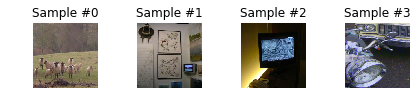

Output for Test Image #0
dog

 Expected
dog


Output for Test Image #1
chair
diningtable

 Expected
bicycle
pottedplant


Output for Test Image #2
bicycle

 Expected
bicycle


Output for Test Image #3
bottle
sofa

 Expected
bottle
person




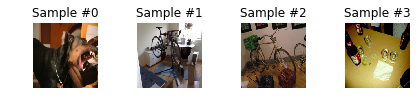

Output for Test Image #0
person

 Expected
person


Output for Test Image #1

 Expected
bird
horse


Output for Test Image #2
person

 Expected
chair
person


Output for Test Image #3
train

 Expected
train




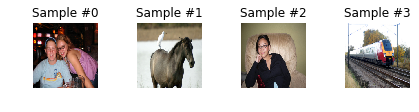

In [52]:
for i_batch, sample_batched in enumerate(multi_class_image_dataloaders['validate']):
    
    # print(i_batch, sample_batched['image'].size(), sample_batched['label'].size())
    
    inputs = sample_batched['image'].to(device)
    labels = sample_batched['label'].to(device)
    
    fig = plt.figure()
                
    with torch.set_grad_enabled(False):
        
        outputs = model_multi_class(inputs)
        output_labels = torch.sigmoid(outputs)
        
        for i in range(4):
            
            ax = plt.subplot(1, 4, i + 1)
            plt.tight_layout()
            ax.set_title('Sample #{}'.format(i))
            ax.axis('off')
            
            inverse_normalize = transforms.Compose(
                [transforms.Normalize(mean = [0., 0., 0.], 
                                      std = [1/0.229, 1/0.224, 1/0.225]),
                 transforms.Normalize(mean = [-0.485, -0.456, -0.406],
                                      std = [1., 1., 1.])]
            )
            inverse_tensor = inverse_normalize(sample_batched['image'][i])
            
            image_test = inverse_tensor.permute(1, 2, 0)
            numpy_image = image_test.numpy()
            # print(numpy_image)
            ax.imshow(numpy_image)
            
            test = output_labels[i] >= 0.50
            expected = labels[i]
            
            print("Output for Test Image #{}".format(i))
            for j in range(len(test)):
                if test[j] == 1:
                    print(train_categories[j + 1])
                    
            print('\n', "Expected")               
            for k in range(len(expected)):
                if expected[k] == 1:
                    print(train_categories[k + 1])
            
            print('\n')
            
            if i == 3:
                plt.show()
    
    if i_batch == 2:
        break